In [1]:
# Initial imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean, mode
from pathlib import Path
from imblearn.pipeline import Pipeline
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, cross_val_score, cross_validate, validation_curve
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

In [2]:
# Loading data
file_path = Path("../eda/reduced_filtered_df.csv")
df = pd.read_csv(file_path)
df.head(1)

,ACD,LT,VCD,SPORTHR,DADMY,delta_spheq,total_positive_screen,MYOPIC
0,3.702,3.392,15.29,4,1,1.358,8,0


In [3]:
# Check dataset balance
df["MYOPIC"].value_counts()

0    323
1     49
Name: MYOPIC, dtype: int64

In [4]:
# Define X,y
label = df["MYOPIC"]
X = df.iloc[:,:-1].copy()

In [5]:
# Holdback Method with stratify as True
X_train, X_test, y_train, y_test = train_test_split(X, label, random_state=42, stratify=label)

In [6]:
len(y_test)

93

## SVC Unbalanced Data
- linear kernel

In [7]:
# create process steps
pipes = [
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=2))
]

# create pipeline
pipeline = Pipeline(pipes)

# Train the scaler with the X_train data.
pipeline.fit(X_train, y_train)

# evaluate model
print(f"Score:  {pipeline.score(X_train, y_train):>10}")

y_train_pred = pipeline.predict(X_train)
print(f" Training Classification Report:  \n {classification_report(y_train, y_train_pred)}")
print(f"-----"*10)
y_test_pred = pipeline.predict(X_test)
print(f" Testing Classification Report:  \n {classification_report(y_test, y_test_pred)}")


Score:  0.8888888888888888
 Training Classification Report:  
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       242
           1       1.00      0.16      0.28        37

    accuracy                           0.89       279
   macro avg       0.94      0.58      0.61       279
weighted avg       0.90      0.89      0.85       279

--------------------------------------------------
 Testing Classification Report:  
               precision    recall  f1-score   support

           0       0.88      1.00      0.94        81
           1       1.00      0.08      0.15        12

    accuracy                           0.88        93
   macro avg       0.94      0.54      0.55        93
weighted avg       0.90      0.88      0.84        93



In [8]:
# evaluation metrics
scoring = ('f1', 'recall', 'precision', 'roc_auc')

# 5 fold cross validation
cv = StratifiedKFold(n_splits=5)

# create process steps
pipes = [
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=2))
]

# create pipeline
pipeline = Pipeline(pipes)

# evaluate pipeline
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean ROC AUC: %.3f' % mean(scores['test_roc_auc']))

Mean f1: 0.050
Mean recall: 0.029
Mean precision: 0.200
Mean ROC AUC: 0.750


## SVC Unbalanced Data GridsearchCV

In [30]:
# create process steps
pipes = [
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=2))
]

# create pipeline
pipeline = Pipeline(pipes)

# set gridsearch parameters
params = {
    "svc__C": [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 1000]
}

# gridsearch with 5 fold cross validation setup
grid = GridSearchCV(pipeline, params);

# Train the scaler with the X_train data.
grid.fit(X_train, y_train)

# evaluate model
print(f"Score:  {grid.score(X_train, y_train):>10}")

y_train_pred = grid.predict(X_train)
print(f" Training Classification Report:  \n {classification_report(y_train, y_train_pred)}")
print(f"-----"*10)
y_test_pred = grid.predict(X_test)
print(f" Testing Classification Report:  \n {classification_report(y_test, y_test_pred)}")

Score:  0.8888888888888888
 Training Classification Report:  
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       242
           1       1.00      0.16      0.28        37

    accuracy                           0.89       279
   macro avg       0.94      0.58      0.61       279
weighted avg       0.90      0.89      0.85       279

--------------------------------------------------
 Testing Classification Report:  
               precision    recall  f1-score   support

           0       0.88      1.00      0.94        81
           1       1.00      0.08      0.15        12

    accuracy                           0.88        93
   macro avg       0.94      0.54      0.55        93
weighted avg       0.90      0.88      0.84        93



In [31]:
# print params
grid.best_params_

{'svc__C': 1}

In [32]:
# evaluation metrics
scoring = ('f1', 'recall', 'precision', 'roc_auc')

# 5 fold cross validation
cv = StratifiedKFold(n_splits=5)

# create process steps
pipes = [
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=2))
]

# create pipeline
pipeline = Pipeline(pipes)

# evaluate pipeline
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean ROC AUC: %.3f' % mean(scores['test_roc_auc']))

Mean f1: 0.050
Mean recall: 0.029
Mean precision: 0.200
Mean ROC AUC: 0.750


## SVC Unbalanced Data PCA GridsearchCV

In [12]:
# create process steps
pipes = [
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=1)),
    ("svc", SVC(random_state=2))
]

# create pipeline
pipeline = Pipeline(pipes)

# set gridsearch parameters
params = {
    "svc__C": [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 1000],
    "pca__n_components":[4,5,6,7]
}

# gridsearch with 5 fold cross validation setup
grid = GridSearchCV(pipeline, params);

# Train the scaler with the X_train data.
grid.fit(X_train, y_train)

# evaluate model
print(f"Score:  {grid.score(X_train, y_train):>10}")

y_train_pred = grid.predict(X_train)
print(f"Training Classification Report:  \n {classification_report(y_train, y_train_pred)}")
print(f"-----"*10)
y_test_pred = grid.predict(X_test)
print(f"Testing Classification Report:  \n {classification_report(y_test, y_test_pred)}")

Score:  0.9032258064516129
Training Classification Report:  
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       242
           1       0.92      0.30      0.45        37

    accuracy                           0.90       279
   macro avg       0.91      0.65      0.70       279
weighted avg       0.90      0.90      0.88       279

--------------------------------------------------
Testing Classification Report:  
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        81
           1       1.00      0.42      0.59        12

    accuracy                           0.92        93
   macro avg       0.96      0.71      0.77        93
weighted avg       0.93      0.92      0.91        93



In [13]:
# print params
grid.best_params_

{'pca__n_components': 4, 'svc__C': 5}

In [14]:
# evaluation metrics
scoring = ('f1', 'recall', 'precision', 'roc_auc')

# 5 fold cross validation
cv = StratifiedKFold(n_splits=5)

# create process steps
pipes = [
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=1, n_components=4)),
    ("svc", SVC(random_state=2, C= 5))
]

# create pipeline
pipeline = Pipeline(pipes)

# evaluate pipeline
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean ROC AUC: %.3f' % mean(scores['test_roc_auc']))

Mean f1: 0.271
Mean recall: 0.211
Mean precision: 0.448
Mean ROC AUC: 0.673


## SVC Balanced Data

In [15]:
# create process steps
pipes = [
    ("over", SMOTE(random_state=1)),
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=2))
]

# create pipeline
pipeline = Pipeline(pipes)

# Train the scaler with the X_train data.
pipeline.fit(X_train, y_train)

# evaluate model
print(f"Score:  {pipeline.score(X_train, y_train):>10}")

y_train_pred = pipeline.predict(X_train)
print(f"Training Classification Report:  \n {classification_report(y_train, y_train_pred)}")
print(f"-----"*10)
y_test_pred = pipeline.predict(X_test)
print(f"Testing Classification Report:  \n {classification_report(y_test, y_test_pred)}")

Score:  0.8709677419354839
Training Classification Report:  
               precision    recall  f1-score   support

           0       0.98      0.87      0.92       242
           1       0.51      0.89      0.65        37

    accuracy                           0.87       279
   macro avg       0.74      0.88      0.78       279
weighted avg       0.92      0.87      0.88       279

--------------------------------------------------
Testing Classification Report:  
               precision    recall  f1-score   support

           0       0.92      0.88      0.90        81
           1       0.38      0.50      0.43        12

    accuracy                           0.83        93
   macro avg       0.65      0.69      0.66        93
weighted avg       0.85      0.83      0.84        93



In [16]:
# evaluation metrics
scoring = ('f1', 'recall', 'precision', 'roc_auc')

# 5 fold cross validation
cv = StratifiedKFold(n_splits=5)

# create process steps
pipes = [
    ("over", SMOTE(random_state=1)),
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=2))
]

# create pipeline
pipeline = Pipeline(pipes)

# evaluate pipeline
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean ROC AUC: %.3f' % mean(scores['test_roc_auc']))

Mean f1: 0.432
Mean recall: 0.589
Mean precision: 0.344
Mean ROC AUC: 0.774


## SVC Balanced Data PCA GridsearchCV

In [17]:
# create process steps
pipes = [
    ("over", SMOTE(random_state=1)),
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=1)),
    ("svc", SVC(random_state=2))
]

# create pipeline
pipeline = Pipeline(pipes)

# set gridsearch parameters
params = {
    "svc__C": [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 1000],
    "pca__n_components":[4,5,6,7]
}

# gridsearch with 5 fold cross validation setup
grid = GridSearchCV(pipeline, params);

# Train the scaler with the X_train data.
grid.fit(X_train, y_train)

# evaluate model
print(f"Score:  {grid.score(X_train, y_train):>10}")

y_train_pred = grid.predict(X_train)
print(f"Training Classification Report:  \n {classification_report(y_train, y_train_pred)}")
print(f"-----"*10)
y_test_pred = grid.predict(X_test)
print(f"Testing Classification Report:  \n {classification_report(y_test, y_test_pred)}")

Score:  0.996415770609319
Training Classification Report:  
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       242
           1       0.97      1.00      0.99        37

    accuracy                           1.00       279
   macro avg       0.99      1.00      0.99       279
weighted avg       1.00      1.00      1.00       279

--------------------------------------------------
Testing Classification Report:  
               precision    recall  f1-score   support

           0       0.90      0.85      0.87        81
           1       0.25      0.33      0.29        12

    accuracy                           0.78        93
   macro avg       0.57      0.59      0.58        93
weighted avg       0.81      0.78      0.80        93



In [18]:
# print params
grid.best_params_

{'pca__n_components': 5, 'svc__C': 1000}

In [19]:
# evaluation metrics
scoring = ('f1', 'recall', 'precision', 'roc_auc')

# 5 fold cross validation
cv = StratifiedKFold(n_splits=5)

# create process steps
pipes = [
    ("over", SMOTE(random_state=1)),
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=1, n_components=5)),
    ("svc", SVC(random_state=2, C=1000))
]

# create pipeline
pipeline = Pipeline(pipes)

# evaluate pipeline
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean ROC AUC: %.3f' % mean(scores['test_roc_auc']))

Mean f1: 0.456
Mean recall: 0.561
Mean precision: 0.412
Mean ROC AUC: 0.787


## SVC Balanced Data Weighted GridsearchCV

In [20]:
# create process steps
pipes = [
    ("over", SMOTE(random_state=1)),
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=2, class_weight='balanced'))
]

# create pipeline
pipeline = Pipeline(pipes)

# set gridsearch parameters
params = {
    "svc__C": [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 1000],
}

# gridsearch with 5 fold cross validation setup
grid = GridSearchCV(pipeline, params);

# Train the scaler with the X_train data.
grid.fit(X_train, y_train)

# evaluate model
print(f"Score:  {grid.score(X_train, y_train):>10}")

y_train_pred = grid.predict(X_train)
print(f"Training Classification Report:  \n {classification_report(y_train, y_train_pred)}")
print(f"-----"*10)
y_test_pred = grid.predict(X_test)
print(f"Testing Classification Report:  \n {classification_report(y_test, y_test_pred)}")

Score:  0.9605734767025089
Training Classification Report:  
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       242
           1       0.78      0.97      0.87        37

    accuracy                           0.96       279
   macro avg       0.89      0.97      0.92       279
weighted avg       0.97      0.96      0.96       279

--------------------------------------------------
Testing Classification Report:  
               precision    recall  f1-score   support

           0       0.88      0.91      0.90        81
           1       0.22      0.17      0.19        12

    accuracy                           0.82        93
   macro avg       0.55      0.54      0.54        93
weighted avg       0.80      0.82      0.81        93



In [21]:
# print params
grid.best_params_

{'svc__C': 10}

In [22]:
# evaluation metrics
scoring = ('f1', 'recall', 'precision', 'roc_auc')

# 5 fold cross validation
cv = StratifiedKFold(n_splits=5)

# create process steps
pipes = [
    ("over", SMOTE(random_state=1)),
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=2, class_weight='balanced', C=10))
]

# create pipeline
pipeline = Pipeline(pipes)

# evaluate pipeline
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean ROC AUC: %.3f' % mean(scores['test_roc_auc']))

Mean f1: 0.390
Mean recall: 0.479
Mean precision: 0.359
Mean ROC AUC: 0.734


## SVC Balanced Data PCA Weighted GridsearchCV 

In [23]:
# create process steps
pipes = [
    ("over", SMOTE(random_state=1)),
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=1)),
    ("svc", SVC(random_state=2, class_weight='balanced'))
]

# create pipeline
pipeline = Pipeline(pipes)

# set gridsearch parameters
params = {
    "svc__C": [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 1000],
    "pca__n_components":[4,5,6,7]
}

# gridsearch with 5 fold cross validation setup
grid = GridSearchCV(pipeline, params);

# Train the scaler with the X_train data.
grid.fit(X_train, y_train)

# evaluate model
print(f"Score:  {grid.score(X_train, y_train):>10}")

y_train_pred = grid.predict(X_train)
print(f" Training Classification Report:  \n {classification_report(y_train, y_train_pred)}")
print(f"-----"*10)
y_test_pred = grid.predict(X_test)
print(f"Testing Classification Report:  \n {classification_report(y_test, y_test_pred)}")

Score:  0.996415770609319
 Training Classification Report:  
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       242
           1       0.97      1.00      0.99        37

    accuracy                           1.00       279
   macro avg       0.99      1.00      0.99       279
weighted avg       1.00      1.00      1.00       279

--------------------------------------------------
Testing Classification Report:  
               precision    recall  f1-score   support

           0       0.90      0.85      0.87        81
           1       0.25      0.33      0.29        12

    accuracy                           0.78        93
   macro avg       0.57      0.59      0.58        93
weighted avg       0.81      0.78      0.80        93



In [24]:
# print params
grid.best_params_

{'pca__n_components': 5, 'svc__C': 1000}

In [25]:
# Training is most likely overfitting
# Need to limit turning parameters to generalize the fit so 
# Will manually increase the C and decrease gamma

### Retest Method

In [26]:
# create process steps
pipes = [
    ("over", SMOTE(random_state=1)),
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=1, n_components=5)),
    ("svc", SVC(random_state=2, class_weight='balanced', C= 1000))
]

# create pipeline
pipeline = Pipeline(pipes)

# Train the scaler with the X_train data.
pipeline.fit(X_train, y_train)

# evaluate model
print(f"Training Score:  {pipeline.score(X_train, y_train):>10}")

y_train_pred = pipeline.predict(X_train)
print(f" Classification Report:  \n {classification_report(y_train, y_train_pred)}")
print(f"-----"*10)
y_test_pred = pipeline.predict(X_test)
print(f" Training Classification Report:  \n {classification_report(y_test, y_test_pred)}")

Training Score:  0.996415770609319
 Classification Report:  
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       242
           1       0.97      1.00      0.99        37

    accuracy                           1.00       279
   macro avg       0.99      1.00      0.99       279
weighted avg       1.00      1.00      1.00       279

--------------------------------------------------
 Training Classification Report:  
               precision    recall  f1-score   support

           0       0.90      0.85      0.87        81
           1       0.25      0.33      0.29        12

    accuracy                           0.78        93
   macro avg       0.57      0.59      0.58        93
weighted avg       0.81      0.78      0.80        93



### Different Cross Validation Method

In [27]:
# evaluation metrics
scoring = ('f1', 'recall', 'precision', 'roc_auc')

# 5 fold cross validation
cv = StratifiedKFold(n_splits=5)

# create process steps
pipes = [
    ("over", SMOTE(random_state=1)),
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=1, n_components=5)),
    ("svc", SVC(random_state=2, class_weight='balanced', C=1000))
]

# create pipeline
pipeline = Pipeline(pipes)

# evaluate pipeline
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean ROC AUC: %.3f' % mean(scores['test_roc_auc']))

Mean f1: 0.456
Mean recall: 0.561
Mean precision: 0.412
Mean ROC AUC: 0.787


## Unbalanced SVC with Class Weights

In [38]:
# create process steps
pipes = [
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=2, class_weight='balanced'))
]

# create pipeline
pipeline = Pipeline(pipes)

# set gridsearch parameters
params = {
    "svc__C": [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 1000]
}

# gridsearch with 5 fold cross validation setup
grid = GridSearchCV(pipeline, params);

# Train the scaler with the X_train data.
grid.fit(X_train, y_train)

# evaluate model
print(f"Score:  {grid.score(X_train, y_train):>10}")

y_train_pred = grid.predict(X_train)
print(f"Training Classification Report:  \n {classification_report(y_train, y_train_pred)}")
print(f"-----"*10)
y_test_pred = grid.predict(X_test)
print(f"Testing Classification Report:  \n {classification_report(y_test, y_test_pred)}")

Score:         1.0
Training Classification Report:  
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       242
           1       1.00      1.00      1.00        37

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279

--------------------------------------------------
Testing Classification Report:  
               precision    recall  f1-score   support

           0       0.88      0.94      0.91        81
           1       0.29      0.17      0.21        12

    accuracy                           0.84        93
   macro avg       0.58      0.55      0.56        93
weighted avg       0.81      0.84      0.82        93



In [36]:
# evaluation metrics
scoring = ('f1', 'recall', 'precision', 'roc_auc')

# 5 fold cross validation
cv = StratifiedKFold(n_splits=5)

# create process steps
pipes = [
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=1)),
    ("svc", SVC(random_state=2, class_weight='balanced'))
]

# create pipeline
pipeline = Pipeline(pipes)

# evaluate pipeline
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean ROC AUC: %.3f' % mean(scores['test_roc_auc']))

Mean f1: 0.429
Mean recall: 0.675
Mean precision: 0.319
Mean ROC AUC: 0.781


- I don't think this is really that much better than the other models since it looks like it is just a tradeoff between precision and recall.  Maybe the model is modifying the threshold criteria?

## Validation Curves

In [28]:
# Validation curve
param_range = [0.001, 0.01, 0.1, 1, 10.0, 20.0]

train_scores, test_scores = validation_curve(estimator=pipeline,
                                             X=X_train, y=y_train,
                                             cv=5,
                                             param_name='svc__C', 
                                             param_range=param_range)

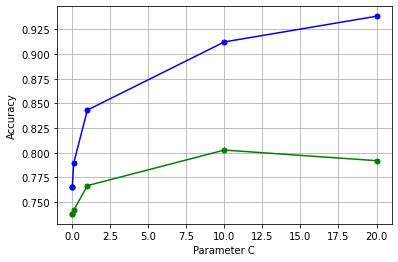

In [29]:
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_mean,
         marker='o', markersize=5,
         color='blue', label='Training Accuracy')
plt.plot(param_range, test_mean,
         marker='o', markersize=5,
         color='green', label='Validation Accuracy')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.grid()
plt.show()


## Analysis

I am starting to learn more about validation plots to see if I can analyze the model quality a bit more effectively.   This is in the early stages.
The SVC model showed that these were probably the most reasonable scores (cross validation scores):  
    Mean f1: 0.457  
    Mean recall: 0.571  
    Mean precision: 0.395  
    Mean ROC AUC: 0.777  